In [2]:
import pandas as pd
import tellurium as te
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm as progbar
from scipy.optimize import curve_fit   
from scipy.stats import linregress

sns.set(context= 'talk',style='ticks',font_scale=1,rc ={'axes.spines.right': False,'axes.spines.top': False,'pdf.fonttype':42},palette='colorblind')

In [10]:
!mv "R12_data.csv" "data/R12_data.csv"

# Baseline model
* Considers rates of nitrate, nitrite and nitrous oxide for 3H11 and R12
* Does not include nitrite inhibition 
* Carrying capacities are fixed and based on growth for nitrate/nitrite
* Rates for acetate estimated from literature 


In [22]:
h11_data=pd.read_csv('data/3H11_data.csv',index_col=0)
h11_data

,time,Acetate,s3H11,NO3,NO2
0,0.0,18.031360,0.01013,9.144505,0.099779
1,23.0,17.815309,0.03307,7.890585,1.061534
2,42.0,16.072696,0.06107,1.350000,7.480505
3,53.0,15.926170,0.07075,0.120916,9.075274
4,71.0,16.255106,0.08789,0.135265,9.215175
5,95.0,16.155678,0.07430,0.138577,9.116233
6,119.0,NaN,0.07030,NaN,NaN
7,142.0,NaN,0.06830,NaN,NaN
8,165.0,NaN,0.06730,NaN,NaN


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

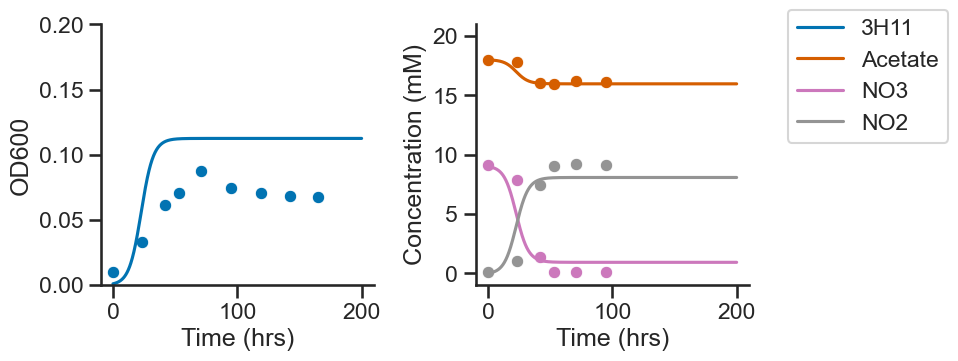

In [16]:
#3H11 isolate model
r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ; (s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNap1*4))+(s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNos1*4));
    
    NO3 -> NO2; (s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNap1));
    
    NO2+NO2 -> N2O;;
   
    N2O -> N2; (s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNos1));
    
    //Species--------------------------------------------------------------------------
    
    -> s3H11; (s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1)))+(s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANos1)));
    
    //---------------------------------------------------------------------------------
    
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.1125; ANos1=0.1; ANap2=0.35; ANir2=0.35;
    NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.0001;
''')

res= r.simulate(0,200,1000)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )


colors = sns.color_palette('colorblind')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))
#ax2 = ax.twinx()


   
sns.lineplot(x='time',y='s3H11',color=colors[0],ax=ax,data=res,label='3H11')
sns.scatterplot(x='time',y='s3H11',color=colors[0],ax=ax,data=h11_data)
for col in ['Acetate','NO3','NO2']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col)
    sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=h11_data)
    

ax.set_ylim(0,0.2)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)
#plt.title('3H11')
handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
#plt.savefig('3H11-Kinetic-model-v0.pdf',bbox_inches='tight')

In [20]:
r12_data =pd.read_csv('data/R12_data.csv',index_col=0)
r12_data

,time,Acetate,sR12,NO3,NO2,N2O
0,0.0,18.031360,0.010930,9.144505,0.099779,0.000000
1,23.0,17.790639,0.015870,8.967896,0.156697,0.015331
2,42.0,18.427579,0.020300,9.531939,0.079565,0.007611
3,53.0,NaN,0.023870,NaN,NaN,NaN
4,71.0,18.258625,0.044930,8.649449,0.107758,0.316667
5,77.0,18.537473,0.062467,8.662695,0.094460,0.534580
6,95.0,17.321905,0.106167,7.075978,0.126908,1.814981
7,119.0,16.723092,0.171890,5.450628,0.139143,3.740492
8,142.0,16.008404,0.223500,4.374420,0.126908,4.162338
9,165.0,15.139714,0.289167,3.323048,0.124781,4.300582


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

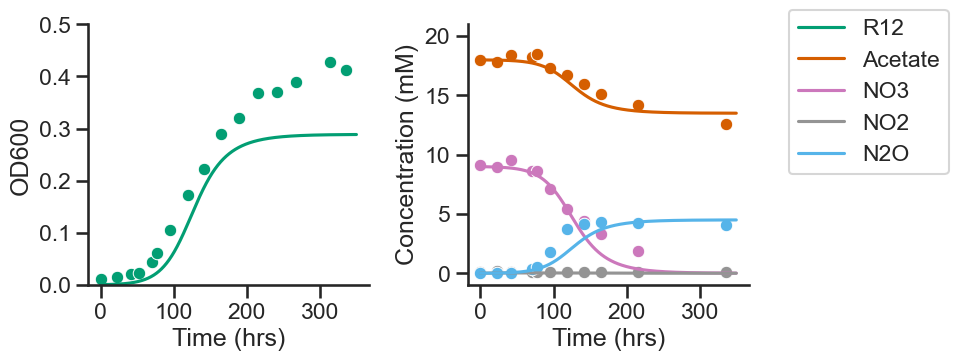

In [24]:
#R12 isolate model
r = te.loada('''
    //Reactions:
    
    Acetate -> ;(sR12*VNap2*NO3/(KNap2+NO3)*(Acetate/(Kace+Acetate))*(1-(sR12/ANap2))/(YNap2*4))+(sR12*VNir2*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-(sR12/ANir2))/(YNir2*4));
    
    NO3 -> NO2;((sR12*VNap2*NO3/(KNap2+NO3))*(Acetate/(Kace+Acetate))*((1-(sR12/ANap2))/YNap2));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/ANir2))/(YNir2*2)));
    
    N2O -> N2;;   
    
    -> sR12; (sR12*VNir2*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-(sR12/ANir2)));
    
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.1; ANos1=0.1; ANap2=0.35; ANir2=0.35;
    NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.001;
''')

res= r.simulate(0,350,1000)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )



colors = sns.color_palette('colorblind')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))
#ax2 = ax.twinx()


   
sns.lineplot(x='time',y='sR12',color=colors[2],ax=ax,data=res,label='R12')
sns.scatterplot(x='time',y='sR12',color=colors[2],ax=ax,data=r12_data)
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col)
    sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=r12_data)
    

ax.set_ylim(0,0.5)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)
#plt.title('3H11')
handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
plt.savefig('R12-Kinetic-model-v0.pdf',bbox_inches='tight')

In [32]:
syn_data=pd.read_csv('data/SynCom_data.csv',index_col=0)
syn_data

,time,Acetate,SynCom,NO3,NO2,N2O
0,0.0,18.031360,0.01140,9.144505,0.099779,0.000000
1,23.0,17.848203,0.02413,8.781905,0.092864,0.067333
2,42.0,16.382195,0.14027,3.830246,2.862165,0.202667
3,53.0,14.993936,0.19830,0.134162,6.211286,0.003333
4,71.0,14.134964,0.24200,0.140784,4.178195,0.002667
5,95.0,13.056951,0.27130,0.128643,1.767424,0.003333
6,119.0,12.663723,0.29967,0.132506,0.102439,0.000000
7,142.0,12.235359,0.29500,0.124779,0.116269,0.000000


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

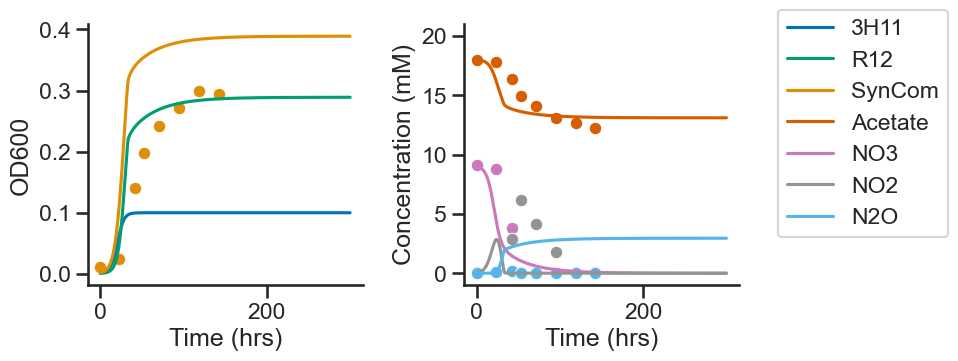

In [34]:
#SynCom model
r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ;(sR12*VNap2*NO3/(KNap2+NO3)*(Acetate/(Kace+Acetate))*(1-(sR12/ANap2))/(YNap2*4))+(sR12*VNir2*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-(sR12/ANir2))/(YNir2*4)) + (s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNap1*4))+(s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNos1*4));
    
    NO3 -> NO2;((sR12*VNap2*NO3/(KNap2+NO3))*(Acetate/(Kace+Acetate))*((1-(sR12/ANap2))/YNap2))+(s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNap1));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/ANir2))/(YNir2*2)));
    
    N2O -> N2; (s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1))/(YNos1));
    
    //Species------------------------------------------------------------------------
    
    -> sR12; (sR12*VNir2*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-(sR12/ANir2)));
    
    -> s3H11; (s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/ANap1)))+(s3H11*VNos1*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/ANos1)));
   
   
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.1; ANos1=0.1; ANap2=0.35; ANir2=0.35;
    NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.001;
''')

res= r.simulate(0,300,1000)
#res= r.simulate(times=syn_data.time)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
res['SynCom']=res['s3H11']+res['sR12']

colors = sns.color_palette('colorblind')
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4),sharex=True)
#ax2 = ax.twinx()

sns.scatterplot(x='time',y='SynCom',color=colors[0],ax=ax,data=syn_data)

for col in ['s3H11','sR12','SynCom']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax,data=syn_data)
    
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=syn_data)

#ax.set_ylim(0,0.2)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)


handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
plt.savefig('SynCom-Kinetic-Model-v0.png',dpi=200,bbox_inches='tight')
plt.savefig('SynCom-Kinetic-Model-v0.pdf',bbox_inches='tight')

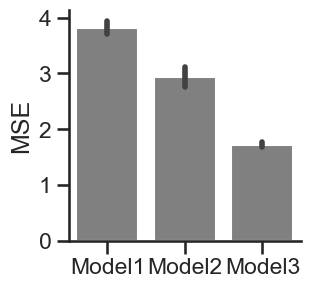

In [36]:
mse={'Model1':[3.813674433920948,3.947622092591157,3.7089476346770534],'Model2':[2.9230231715840445,2.754662818630991,3.1206043839634114],'Model3':[1.7128074158255422,1.778921421324469,1.6759142697529295]}
df=pd.DataFrame(mse)
df=df.stack().reset_index()
plt.figure(figsize=(3,3))
sns.barplot(x='level_1',y=0,data=df,color='grey')
#sns.stripplot(x='level_1',y=0,data=df,color='k',alpha=0.5)
plt.ylabel('MSE')
plt.xlabel('')
plt.savefig('SynCom-model-MSE.pdf',bbox_inches='tight')

In [38]:
from scipy.stats import ttest_ind
x1=df[df.level_1=='Model1'][0]
x2=df[df.level_1=='Model2'][0]
x3=df[df.level_1=='Model3'][0]

print(ttest_ind(x1,x2,equal_var=False))
print(ttest_ind(x1,x3,equal_var=False))
print(ttest_ind(x2,x3,equal_var=False))

TtestResult(statistic=7.051360742044424, pvalue=0.003671494088372392, df=3.4436929500867626)
TtestResult(statistic=27.8786359969971, pvalue=0.00019409949875698993, df=2.734622043506966)
TtestResult(statistic=11.006019625911001, pvalue=0.004696356492123416, df=2.32262067930823)


# Model update 1
* Added inhibitory effect of nitrite for both R12 and 3H11
    * Effect is applied to biomass and metabolites
* Carrying capacity as a function of initial and expected nitrate/nitrite/nitrous oxide

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

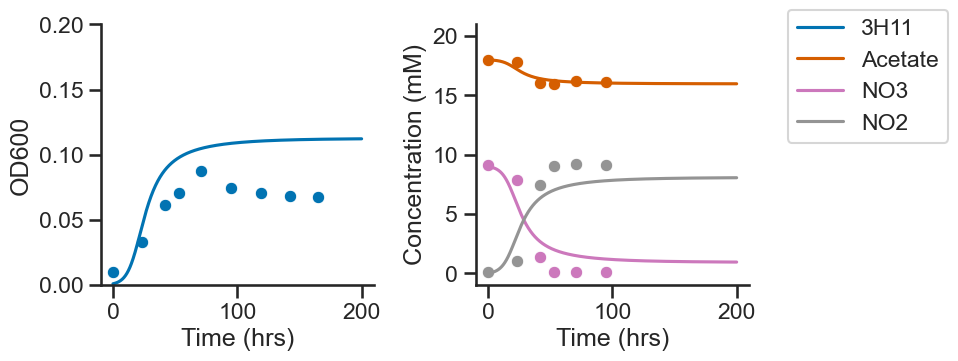

In [40]:
#3H11 isolate model

r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ; (s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4));
    
    NO3 -> NO2; (s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1));
    
    NO2+NO2 -> N2O;;
   
    N2O -> N2; (s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1));
    
    
    //Species--------------------------------------------------------------------------
    
    -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)));
    
    //---------------------------------------------------------------------------------
    
    //Constants:
    
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.35; ANir2=0.35;
    KiR12=14.1; Ki3H11=9.15;NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.001; A3H11=(ANap1*NO3)
''')

res= r.simulate(0,200,1000)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )


colors = sns.color_palette('colorblind')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))
#ax2 = ax.twinx()


   
sns.lineplot(x='time',y='s3H11',color=colors[0],ax=ax,data=res,label='3H11')
sns.scatterplot(x='time',y='s3H11',color=colors[0],ax=ax,data=h11_data)
for col in ['Acetate','NO3','NO2']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col)
    sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=h11_data)
    

ax.set_ylim(0,0.2)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)
#plt.title('3H11')
handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
plt.savefig('3H11-Kinetic-Model-v1.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

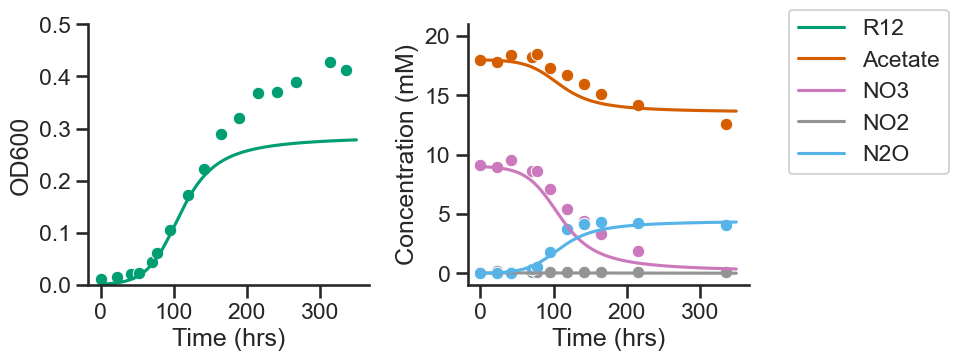

In [42]:
colors = sns.color_palette('colorblind')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
#R12 isolate model
r = te.loada('''
    //Reactions:
    
    Acetate -> ;(sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*(Acetate/(Kace+Acetate))*(1-(sR12/AR12))/(YNap2*4))+(sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4));
    
    NO3 -> NO2;((sR12*VNap2*NO3/(KNap2+NO3))*(1-(NO2/KiR12))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/YNap2));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(1-(NO2/KiR12))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)));
    
    N2O -> N2;;   
    
    -> sR12; sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-(sR12/AR12))
    
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
    KiR12=14.1; Ki3H11=9.15;NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.002; sR12= 0.002; A3H11=(ANap1*NO3); AR12=ANir2*NO3;
''')

res= r.simulate(0,350,1000)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )

fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4))
#ax2 = ax.twinx()

   
sns.lineplot(x='time',y='sR12',color=cdict['sR12'],ax=ax,data=res,label='R12')
sns.scatterplot(x='time',y='sR12',color=cdict['sR12'],ax=ax,data=r12_data)
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col)
    sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=r12_data)
    

ax.set_ylim(0,0.5)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)
#plt.title('R12')

handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
plt.savefig('R12-Kinetic-Model-v1.pdf',bbox_inches='tight')

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

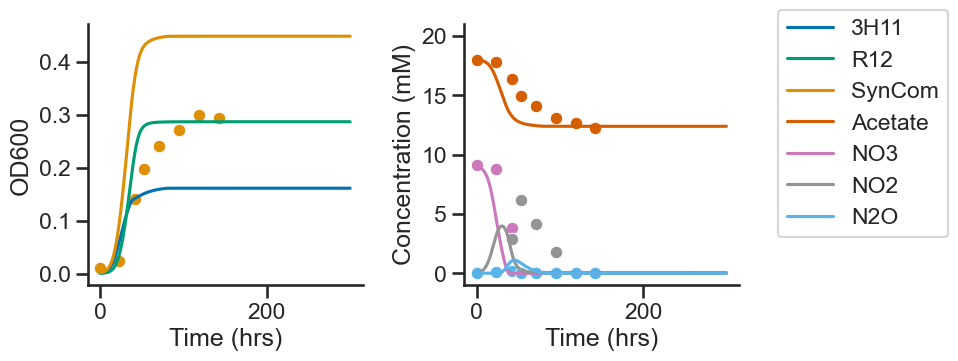

In [44]:
#SynCom model
colors = sns.color_palette('colorblind')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNap2*4)+sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4)+s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4)+s3H11*VNos1*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4);
    
    NO3 -> NO2;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/YNap2+s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNap1*(1-(NO2/Ki3H11));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)))*(1-(NO2/KiR12));
    
    N2O -> N2; (s3H11*VNos1)*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNos1*(1-(NO2/Ki3H11));
    
    //Species------------------------------------------------------------------------
    
    -> sR12; (sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-sR12/AR12));
    
    -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)));
   
   
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
    KiR12=14.1; Ki3H11=9.15;NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.001; A3H11=(ANap1*NO3+ANos1*NO3/2); AR12=ANir2*NO3;
''')
res= r.simulate(0,300,1000)
#res= r.simulate(times=syn_data.time.values)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
res['SynCom']=res['s3H11']+res['sR12']

colors = sns.color_palette('colorblind')
fig,(ax,ax2) = plt.subplots(1,2,figsize=(10,4),sharex=True)
#ax2 = ax.twinx()

sns.scatterplot(x='time',y='SynCom',color=colors[0],ax=ax,data=syn_data)

for col in ['s3H11','sR12','SynCom']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax,data=syn_data)
    
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=syn_data)

#ax.set_ylim(0,0.2)
#ax2.set_ylim(0,0.2)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)


handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
plt.savefig('SynCom-Kinetic-Model-v1.png',dpi=200,bbox_inches='tight')
plt.savefig('SynCom-Kinetic-Model-v1.pdf',bbox_inches='tight')

# Assumption that NO leaks out of R12 
* In the case of no NO reduction, R12 would get 1/2 electrons and thus 1/2 biomass for nitrite
* Assume 3H11 gets proportional amount of biomass from NO as N2O (e.g., multiply N2O contribution by 2x)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

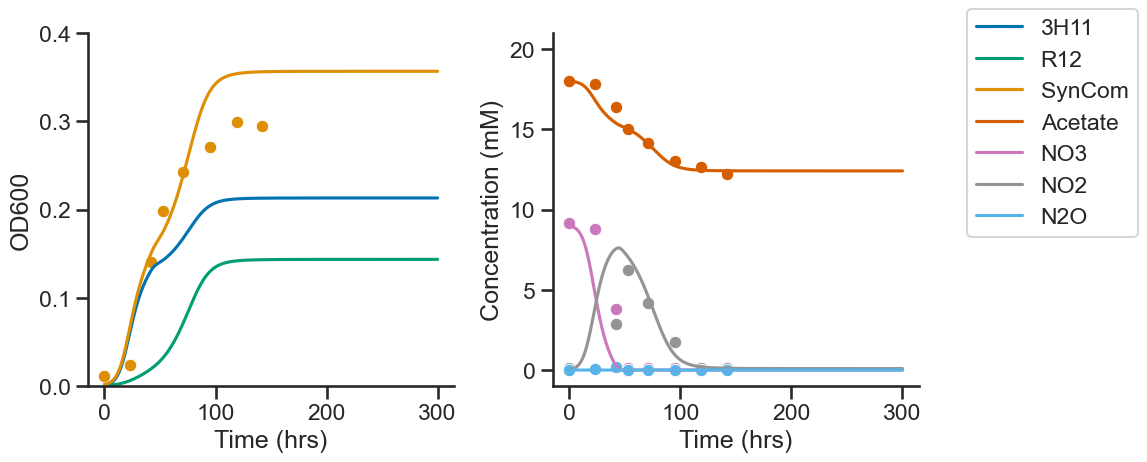

In [46]:
#SynCom model
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNap2*4)+sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4)+s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4)+s3H11*VNos1*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4);
    
    NO3 -> NO2;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/YNap2+s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNap1*(1-(NO2/Ki3H11));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)))*(1-(NO2/KiR12));
    
    N2O -> N2; (s3H11*VNos1)*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNos1*(1-(NO2/Ki3H11));
    
    //Species------------------------------------------------------------------------
    
    -> sR12; (sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-sR12/AR12))/2;
    
    -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)))*2;
   
   
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
    KiR12=14.1; Ki3H11=9.15;NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.001; sR12= 0.001; A3H11=(ANap1*NO3+ANos1*NO3); AR12=ANir2*NO3/2;
''')
res= r.simulate(0,300,1000)
#res= r.simulate(times=syn_data.time.values)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
res['SynCom']=res['s3H11']+res['sR12']

colors = sns.color_palette('colorblind')
fig,(ax,ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True)
#ax2 = ax.twinx()

sns.scatterplot(x='time',y='SynCom',color=colors[0],ax=ax,data=syn_data)

for col in ['s3H11','sR12','SynCom']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax,data=syn_data)
    
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=syn_data)

#ax.set_ylim(0,0.2)
ax.set_ylim(0,0.4)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)


handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()
#plt.savefig('SynCom-Kinetic-Model-v2.png',dpi=200,bbox_inches='tight')
#plt.savefig('SynCom-Kinetic-Model-v2.pdf',bbox_inches='tight')

# Looking at biomass ratio

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

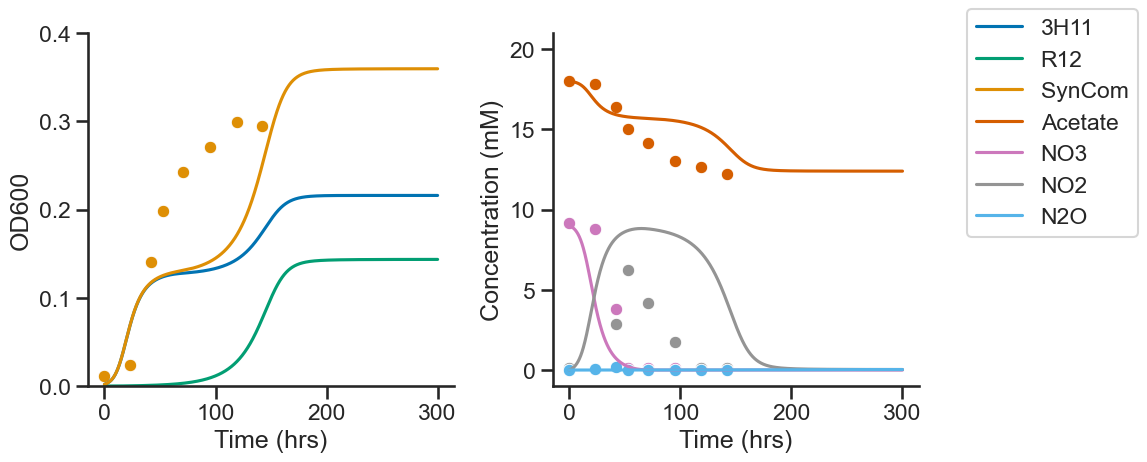

In [48]:
#SynCom model
r = te.loada('''
    //Reactions:
    
    //Substrates------------------------------------------------------------------------
    
    Acetate -> ;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNap2*4)+sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4)+s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4)+s3H11*VNos1*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4);
    
    NO3 -> NO2;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/YNap2+s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNap1*(1-(NO2/Ki3H11));
    
    NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)))*(1-(NO2/KiR12));
    
    N2O -> N2; (s3H11*VNos1)*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNos1*(1-(NO2/Ki3H11));
    
    //Species------------------------------------------------------------------------
    
    -> sR12; (sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-sR12/AR12))/2;
    
    -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)))*2;
   
   
    //Constants:
    
    VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
    YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
    KiR12=14.1; Ki3H11=9.15;NO3=9; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=.98*0.002; sR12= 0.002-s3H11; A3H11=(ANap1*NO3+ANos1*NO3); AR12=ANir2*NO3/2;
''')
cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
res= r.simulate(0,300,1000)
res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
res['SynCom']=res['s3H11']+res['sR12']

colors = sns.color_palette('colorblind')
fig,(ax,ax2) = plt.subplots(1,2,figsize=(12,5),sharex=True)
#ax2 = ax.twinx()

sns.scatterplot(x='time',y='SynCom',color=colors[0],ax=ax,data=syn_data)

for col in ['s3H11','sR12','SynCom']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax,data=syn_data)
    
for col in ['Acetate','NO3','NO2','N2O']:
    sns.lineplot(x='time',y=col,color=cdict[col],ax=ax2,data=res,label=col.replace('s',''))
    if col in syn_data.columns:
        sns.scatterplot(x='time',y=col,color=cdict[col],ax=ax2,data=syn_data)

#ax.set_ylim(0,0.2)
ax.set_ylim(0,0.4)
ax.set_xlabel('Time (hrs)')
ax2.set_xlabel('Time (hrs)')
ax.set_ylabel('OD600')
ax2.set_ylabel('Concentration (mM)')
ax2.set_ylim(-1,21)


handles=ax.get_legend_handles_labels()[0]+ax2.get_legend_handles_labels()[0]
labels=ax.get_legend_handles_labels()[1]+ax2.get_legend_handles_labels()[1]
ax.get_legend().remove()
ax2.legend(handles,labels,bbox_to_anchor=(1.1,1.1),loc=2)
fig.tight_layout()

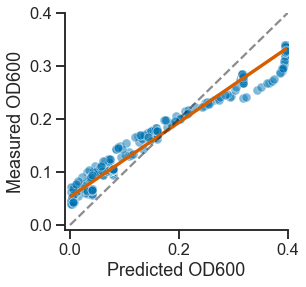

In [325]:
df=pd.DataFrame(np.array([y_model,y_data])).T
df.columns=['model','data']
smp=df.sample(500)
plt.figure(figsize=(4,4))
sns.scatterplot(x='model',y='data',data=smp,alpha=0.5)
sns.regplot(x='model',y='data',data=smp,scatter=False,color='r')
plt.plot((0,.4),(0,.4),'k--',alpha=0.5)
plt.xlim(-.01,.4)
plt.ylim(-.01,.4)
plt.xlabel('Predicted OD600')
plt.ylabel('Measured OD600')
plt.savefig('SynCom-nitrate-Exp-vs-model-growth-corr.pdf',bbox_inches='tight')

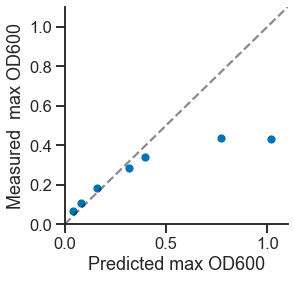

In [328]:
plt.figure(figsize=(4,4))
df=pd.DataFrame(max_ods)
sns.scatterplot(x='model',y='data',data=df,marker='o')
plt.xlim(0,1.1)
plt.ylim(0,1.1)
plt.plot((0,1.1),(0,1.1),'k--',alpha=0.5)
plt.xlabel('Predicted max OD600')
plt.ylabel('Measured  max OD600')
plt.savefig('SynCom-nitrate-Exp-vs-model-maxod.pdf',bbox_inches='tight')

In [52]:
from sklearn.metrics import auc
colors = sns.color_palette('colorblind')
no2_auc=[]
no3_auc=[]
n2o_auc=[]
cond=[]
max_no2=[]
biomass=[]
for i in np.linspace(.001,.999,10):
    for j in np.linspace(1,30,10):
        #SynCom model
        cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
        r = te.loada('''
            //Reactions:

            //Substrates------------------------------------------------------------------------

            Acetate -> ;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNap2*4)+sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4)+s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4)+s3H11*VNos1*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4);

            NO3 -> NO2;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/YNap2+s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNap1*(1-(NO2/Ki3H11));

            NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)))*(1-(NO2/KiR12));

            N2O -> N2; (s3H11*VNos1)*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNos1*(1-(NO2/Ki3H11));

            //Species------------------------------------------------------------------------

            -> sR12; (sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-sR12/AR12))/2;

            -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)))*2;


            //Constants:

            VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
            YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
            KiR12=14.1; Ki3H11=9.15;NO3=%s; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=%s*0.002; sR12= 0.002-s3H11; A3H11=(ANap1*NO3+ANos1*NO3); AR12=ANir2*NO3/2;
        '''%(j,i))

        res= r.simulate(0,300,1000)
        res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
        res['SynCom']=res['s3H11']+res['sR12']
    
        cond.append((i,j))
        no2_auc.append(auc(res.time,res.NO2))
        no3_auc.append(auc(res.time,res.NO3))
        n2o_auc.append(auc(res.time,res.N2O))
        max_no2.append(max(res.NO2))
        biomass.append(max(res.SynCom))

<Axes: xlabel='3H11_frac', ylabel='nitrate'>

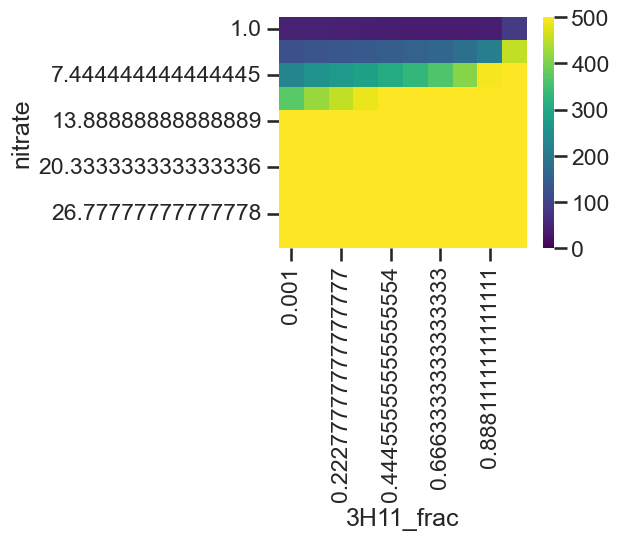

In [54]:
res=pd.DataFrame(cond,columns=['3H11_frac','nitrate'])
res['max_no2']=max_no2
res['no2_auc']=no2_auc
res['biomass']=biomass
df=res.pivot(index='nitrate',columns='3H11_frac',values='no2_auc')
plt.figure(figsize=(4,3))
sns.heatmap(df,cmap='viridis',vmin=0,vmax=500)
#plt.savefig('NO2-AUC-Pred-Heatmap.pdf',bbox_inches='tight')

In [58]:
trans=[]
for col in df.columns:
    trans.append(df[df>=500][col].dropna().index[0])
trans

[13.88888888888889,
 13.88888888888889,
 13.88888888888889,
 13.88888888888889,
 10.666666666666668,
 10.666666666666668,
 10.666666666666668,
 10.666666666666668,
 10.666666666666668,
 7.444444444444445]

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:233: RuntimeWarning:

invalid value encountered in divide

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/nonparametric/smoothers_lowess.py:240: RuntimeWarning:

invalid value encountered in divide



Text(0.5, 0, 'Transition NO$_3$ (mM)')

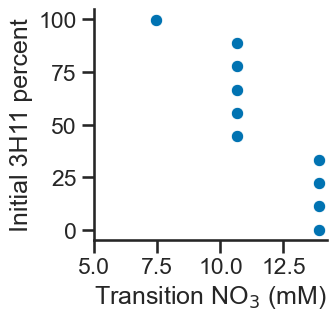

In [60]:
import statsmodels.api as sm

def lowess_with_confidence_bounds(
    x, y, eval_x, N=500, conf_interval=0.95, lowess_kw=None
):
    """
    Perform Lowess regression and determine a confidence interval by bootstrap resampling
    """
    # Lowess smoothing
    smoothed = sm.nonparametric.lowess(exog=x, endog=y, xvals=eval_x, **lowess_kw)

    # Perform bootstrap resamplings of the data
    # and  evaluate the smoothing at a fixed set of points
    smoothed_values = np.empty((N, len(eval_x)))
    for i in range(N):
        sample = np.random.choice(len(x), len(x), replace=True)
        sampled_x = x[sample]
        sampled_y = y[sample]

        smoothed_values[i] = sm.nonparametric.lowess(
            exog=sampled_x, endog=sampled_y, xvals=eval_x, **lowess_kw
        )

    # Get the confidence interval
    sorted_values = np.sort(smoothed_values, axis=0)
    bound = int(N * (1 - conf_interval) / 2)
    bottom = sorted_values[bound - 1]
    top = sorted_values[-bound]

    return smoothed, bottom, top

plt.figure(figsize=(3,3))
x_vals=np.array(trans)
y_vals=df.columns*100
eval_x = np.linspace(min(x_vals),max(x_vals),100)
smoothed, bottom, top = lowess_with_confidence_bounds(x_vals, y_vals, eval_x, lowess_kw={"frac": 0.4},conf_interval=0.68)
plt.plot(eval_x,smoothed,color='r')
plt.fill_between(eval_x,bottom,top,color='r',alpha=0.2)
sns.scatterplot(y=y_vals,x=x_vals)
plt.xticks([5,7.5,10,12.5])
plt.ylabel('Initial 3H11 percent')
plt.xlabel('Transition NO$_3$ (mM)')
#plt.savefig('Nitrite-AUC-trans-vs-3H11-comp.pdf',bbox_inches='tight')

# Looking at Nitrate variation

In [64]:
from sklearn.metrics import auc

no2_auc=[]
no3_auc=[]
n2o_auc=[]
no3_conc=[]
max_no2=[]
max_n2o=[]
final_n2o=[]
for i in np.linspace(1,40,100):
    #SynCom model
    cdict={'SynCom':colors[1],'s3H11':colors[0],'sR12':colors[2],'Acetate':colors[3],'NO3':colors[4],'NO2':colors[7],'N2O':colors[9]}
    r = te.loada('''
        //Reactions:

        //Substrates------------------------------------------------------------------------

        Acetate -> ;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNap2*4)+sR12*VNir2*NO2/(KNir2+NO2)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/(YNir2*4)+s3H11*VNap1*NO3/(KNap1+NO3)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNap1*4)+s3H11*VNos1*N2O/(KNos1+N2O)*(1-(NO2/Ki3H11))*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/(YNos1*4);

        NO3 -> NO2;sR12*VNap2*NO3/(KNap2+NO3)*(1-(NO2/KiR12))*Acetate/(Kace+Acetate)*(1-(sR12/AR12))/YNap2+s3H11*VNap1*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNap1*(1-(NO2/Ki3H11));

        NO2+NO2 -> N2O;((sR12*VNir2*NO2/(KNir2+NO2))*(Acetate/(Kace+Acetate))*((1-(sR12/AR12))/(YNir2*2)))*(1-(NO2/KiR12));

        N2O -> N2; (s3H11*VNos1)*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))/YNos1*(1-(NO2/Ki3H11));

        //Species------------------------------------------------------------------------

        -> sR12; (sR12*VNir2*(1-(NO2/KiR12))*NO2/(KNir2+NO2)*Acetate/(Kace+Acetate)*(1-sR12/AR12))/2;

        -> s3H11; (s3H11*VNap1)*NO3/(KNap1+NO3)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11))*(1-(NO2/Ki3H11))+(s3H11*VNos1*(1-(NO2/Ki3H11))*N2O/(KNos1+N2O)*Acetate/(Kace+Acetate)*(1-(s3H11/A3H11)))*2;


        //Constants:

        VNap1=0.21; VNos1=0.06; VNap2=0.07; VNir2=0.24; KNap1=0.1; KNos1=0.0014;  KNap2=4.3; KNir2=0.1;
        YNap1=0.0138;  YNos1=0.0101; YNap2=0.03; YNir2=0.032;  Kace=0.01; Ya1=0.1; Ya2=0.1; ANap1=0.0125; ANos1=0.0115; ANap2=0.0356; ANir2=0.0319;
        KiR12=14.1; Ki3H11=9.15;NO3=%s; NO2=0; NO=0; N2O=0; N2=0; Acetate=18; s3H11=0.5*0.002; sR12= 0.002-s3H11; A3H11=(ANap1*NO3+ANos1*NO3); AR12=ANir2*NO3/2;
    '''%(i))

    res= r.simulate(0,300,1000)
    res=pd.DataFrame(res,columns=[x[1:-1] if '[' in x else x for x in res.colnames] )
    res['SynCom']=res['s3H11']+res['sR12']
    
    no3_conc.append(i)
    no2_auc.append(auc(res.time,res.NO2))
    no3_auc.append(auc(res.time,res.NO3))
    n2o_auc.append(auc(res.time,res.N2O))
    max_no2.append(max(res.NO2))
    max_n2o.append(max(res.N2O))
    final_n2o.append(res.N2O.values[-1])

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed

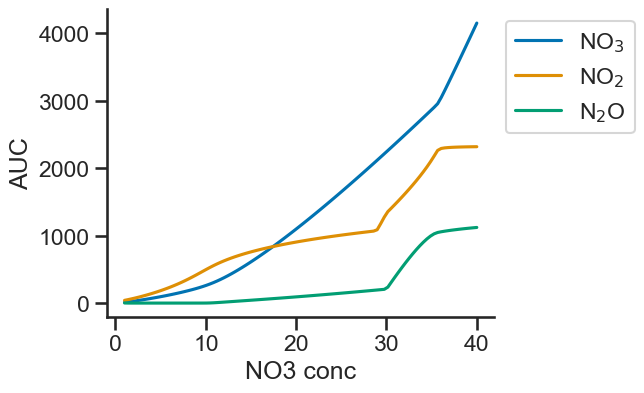

In [66]:
plt.figure(figsize=(5,4))
sns.lineplot(x=no3_conc,y=no3_auc,label='NO$_3$')
sns.lineplot(x=no3_conc,y=no2_auc,label='NO$_2$')
sns.lineplot(x=no3_conc,y=n2o_auc,label='N$_2$O')
plt.xlabel('NO3 conc')
plt.ylabel('AUC')
plt.legend(bbox_to_anchor=(1,1))